Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [5]:
from IPython.core.debugger import set_trace
from IPython.display import display

data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'originated', 'a', 'as', 'term', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['originated', 'term', 'anarchism', 'a', 'originated', 'of', 'as', 'term']


Train a skip-gram model.

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [7]:
num_steps = 240001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_normalized_embeddings = normalized_embeddings.eval()
  final_embeddings = embeddings.eval()

Initialized
Average loss at step 0: 7.830663
Nearest to from: baptists, rae, incompleteness, analyzer, pxe, adhesives, mental, autistics,
Nearest to two: moyers, compliance, collages, romanian, computes, ceasefire, blooms, mescaline,
Nearest to see: ephraem, reification, multiplications, spinoff, rossetti, notepad, flamenco, amnon,
Nearest to if: peace, reciprocate, weaning, predication, founders, fielding, ttl, dugout,
Nearest to after: mahuad, continuations, briand, agrippina, goon, uranhay, elena, tms,
Nearest to have: vagantes, moro, arteries, aesop, secularization, bromine, borman, amish,
Nearest to th: grazed, oscillating, dhcp, satrapy, prophase, assassins, uncollected, dimension,
Nearest to to: eutelsat, harum, mares, cliath, meuse, fife, poirot, ovaries,
Nearest to world: chieftains, fuels, predictor, preliminary, sparta, protester, memetic, camcorder,
Nearest to would: bicoid, migrant, rebecca, municipality, schlegel, divorcing, mercantilism, epicurus,
Nearest to zero: wither

In [8]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_normalized_embeddings[1:num_points+1, :])

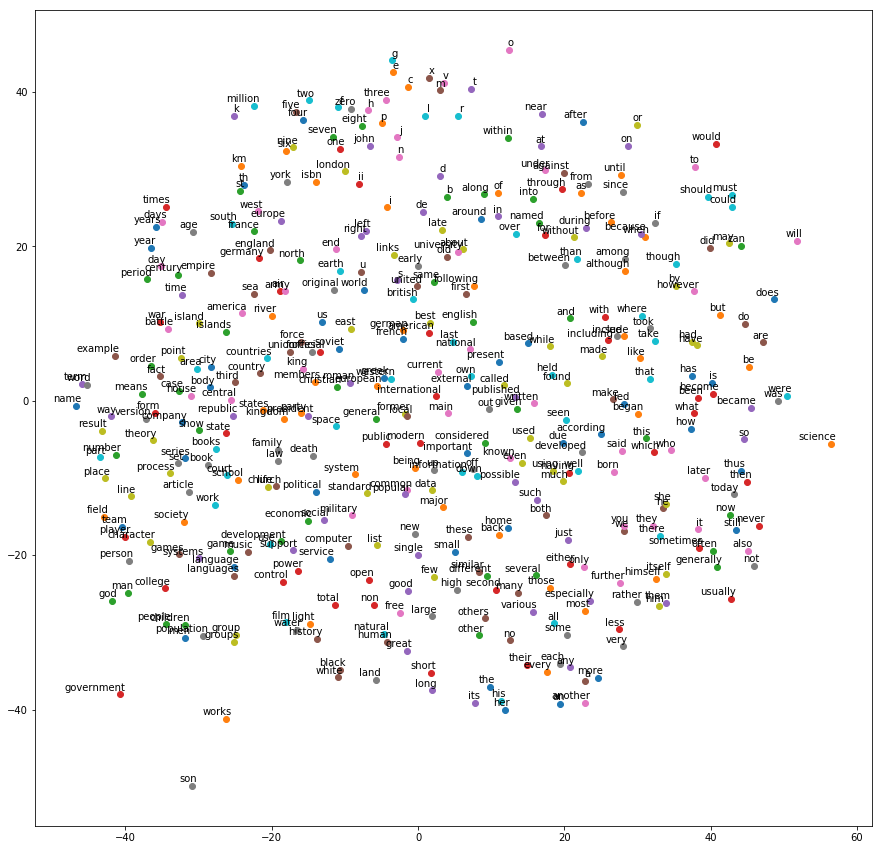

In [9]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [10]:
def get_question_answer(word1, word2, word3):
    idx1 = dictionary[word1]
    idx2 = dictionary[word2]
    idx3 = dictionary[word3]
    summed = final_embeddings[idx2,:] - final_embeddings[idx1,:] + final_embeddings[idx3,:]
    neg_scaled_sim = -np.dot(final_normalized_embeddings, summed)

    ap = neg_scaled_sim.argpartition(3)
    # argpartition() does not sort the partition, so it must be sorted separately.
    ap = ap[neg_scaled_sim[ap].argsort()]
    for idx in ap[0:3]:
        if idx != idx1 and idx != idx2 and idx != idx3:
            return reverse_dictionary[idx]
    return reverse_dictionary[ap[3]]

In [11]:
#From test file
display(get_question_answer('london', 'england', 'paris')) #england - london + paris = france
display(get_question_answer('boy', 'girl', 'he')) #girl - boy + he = she
display(get_question_answer('girl', 'boy', 'she')) #boy - girl + she = he

#Myself
display(get_question_answer('jerusalem','israel','paris')) #israel - jerusalem + paris = WRONG
display(get_question_answer('england','london','france')) #london - england + france = WRONG

'france'

'she'

'he'

'belgium'

'paris'

In [12]:
url = 'https://raw.githubusercontent.com/tmikolov/word2vec/master/'

#Download the raw file
filename = maybe_download('questions-words.txt', 603955)

def is_test_in_dictionary(test):
    test_ids = [dictionary.get(word) for word in test]
    return test_ids.count(None) == 0

def perform_word2vec_test():
    with open(filename, 'rb') as qa_file:
        #Prepare test from file
        categories = []
        tests_by_category = {}
        for line in qa_file.readlines():
            is_category = line.startswith(':')
            if (is_category == True):
                category_name = line[1:].strip()
                categories.append(category_name)
                tests_by_category[category_name] = []
            else:
                last_category = categories[-1]
                test = line.lower().strip().split(' ')
                if (is_test_in_dictionary(test)):
                    tests_by_category[last_category].append(test)
        print('Categories count: ', len(categories))
        print('Tests count: ', [ (c , len(tests_by_category[c])) for c in categories ])
        print('\n.')

        #Perform the test
        success_by_category = dict(zip(categories, [[] for x in categories]))
        total_tests_size = total_success_count = 0
        for category in categories:
            test_size = len(tests_by_category[category])
            success_count = 0
            for test in tests_by_category[category]:
                right_answer = test[3]
                model_answer = get_question_answer(test[0], test[1], test[2])
                if (right_answer == model_answer):
                    success_count += 1
                    success_by_category[category].append(test)
            accuracy = float(success_count) / test_size * 100
            print(category)
            for test in success_by_category[category]:
                print('\t{} - {} + {} = {}'.format(test[1],test[0],test[2],test[3]))
            print('Accuracy: {}% ({} / {})\n'.format(accuracy, success_count, test_size))
            total_tests_size += test_size
            total_success_count += success_count
        total_accuracy = float(total_success_count) / total_tests_size * 100
        print('Total accuracy: {}% ({} / {})'.format(total_accuracy, total_success_count, total_tests_size))

Found and verified questions-words.txt


In [13]:
perform_word2vec_test()

Categories count:  14
Tests count:  [('capital-common-countries', 506), ('capital-world', 2900), ('currency', 458), ('city-in-state', 2060), ('family', 342), ('gram1-adjective-to-adverb', 930), ('gram2-opposite', 506), ('gram3-comparative', 1332), ('gram4-superlative', 756), ('gram5-present-participle', 1056), ('gram6-nationality-adjective', 1521), ('gram7-past-tense', 1482), ('gram8-plural', 1190), ('gram9-plural-verbs', 812)]

.
capital-common-countries
	greece - athens + paris = france
	iraq - baghdad + athens = greece
	china - beijing + berlin = germany
	china - beijing + madrid = spain
	china - beijing + paris = france
	switzerland - bern + cairo = egypt
	egypt - cairo + athens = greece
	australia - canberra + berlin = germany
	cuba - havana + moscow = russia
	finland - helsinki + madrid = spain
	finland - helsinki + paris = france
	finland - helsinki + berlin = germany
	afghanistan - kabul + madrid = spain
	england - london + paris = france
	spain - madrid + cairo = egypt
	france

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [136]:
from IPython.core.debugger import set_trace
from IPython.display import display

data_index = 0

def generate_batch_cbow(batch_size, skip_window):
  global data_index
  batch = np.ndarray(shape=(batch_size, 2*skip_window), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  for i in range(batch_size):
    target = (data_index + i) % len(data)
    labels[i] = data[target]
    batch_index = 0
    for j in range(2*skip_window+1):
      context = (target - skip_window + j) % len(data)
      if (target != context):
        batch[i][batch_index] = data[context]
        batch_index += 1
    #display(batch[i])
  data_index += batch_size % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for skip_window in [(1), (2)]:
    data_index = 0
    batch, labels = generate_batch_cbow(batch_size=8, skip_window=skip_window)
    #display(batch.shape)
    print('\nwith skip_window = %d:' % (skip_window))
    print('    batch:', [[reverse_dictionary[bii] for bii in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with skip_window = 1:
    batch: [['b', 'originated'], ['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used']]
    labels: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with skip_window = 2:
    batch: [['five', 'b', 'originated', 'as'], ['b', 'anarchism', 'as', 'a'], ['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first'], ['term', 'of', 'first', 'used'], ['of', 'abuse', 'used', 'against']]
    labels: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']


In [137]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, 2*skip_window])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  
  # Model.
  # Look up embeddings for inputs.
  context_lookup = tf.nn.embedding_lookup(embeddings, train_dataset)
  context = tf.reduce_sum(context_lookup, 1) #tf.reduce_mean(context_lookup, 1)
  display(context_lookup)
  display(context)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=context,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

<tf.Tensor 'embedding_lookup:0' shape=(128, 2, 128) dtype=float32>

<tf.Tensor 'Sum:0' shape=(128, 128) dtype=float32>

In [30]:
with tf.Session(graph=tf.Graph()) as session:
    mat = tf.constant([[1.0, 2, 3], [4, 5, 6], [7, 8, 9]])
    ids = tf.constant([0, 1])
    x = tf.nn.embedding_lookup(mat, ids)
    #x = tf.reduce_sum(x, 0) / 2.0
    x = tf.reduce_mean(x, 0)
    display(x.eval())

array([ 2.5,  3.5,  4.5], dtype=float32)

In [138]:
num_steps = 240001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch_cbow(
      batch_size, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_normalized_embeddings = normalized_embeddings.eval()
  final_embeddings = embeddings.eval()

Initialized
Average loss at step 0: 7.433289
Nearest to such: decentralized, nicolson, simcoe, rod, albuquerque, chickens, confessed, nss,
Nearest to use: hansard, chronica, concurred, kinder, alcs, stansted, hanford, dulce,
Nearest to states: rnberg, largest, licinius, hutterites, publicised, absent, broadcasts, encroachment,
Nearest to been: bhutan, baka, intrusion, theremin, marcantonio, ideological, unidad, pete,
Nearest to eight: keating, bhp, retaken, retracted, egalitarianism, preacher, fedora, moog,
Nearest to may: cologne, age, retake, ciboney, cleopatra, polarizing, walcott, miya,
Nearest to two: axel, astronomical, pharmacologic, mistress, rory, sci, duma, jaffa,
Nearest to b: tantra, attendances, ejaculate, karenga, backbones, lysander, cumont, middleton,
Nearest to about: battlecruiser, refreshed, brunel, unresolved, securities, abjuration, tiki, aglaulus,
Nearest to no: northumbrian, accountable, relationship, uga, interfered, armand, annexing, park,
Nearest to into: katy

In [139]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_normalized_embeddings[1:num_points+1, :])

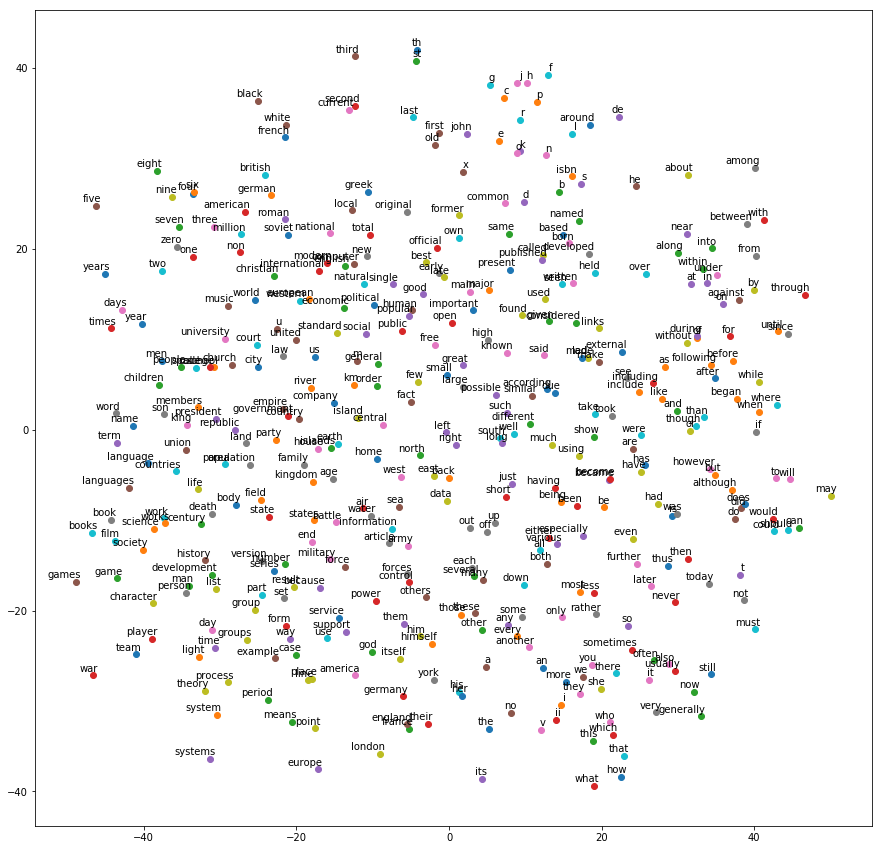

In [140]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [143]:
perform_word2vec_test()

Categories count:  14
Tests count:  [('capital-common-countries', 506), ('capital-world', 2900), ('currency', 458), ('city-in-state', 2060), ('family', 342), ('gram1-adjective-to-adverb', 930), ('gram2-opposite', 506), ('gram3-comparative', 1332), ('gram4-superlative', 756), ('gram5-present-participle', 1056), ('gram6-nationality-adjective', 1521), ('gram7-past-tense', 1482), ('gram8-plural', 1190), ('gram9-plural-verbs', 812)]

.
capital-common-countries
	greece - athens + cairo = egypt
	thailand - bangkok + berlin = germany
	china - beijing + berlin = germany
	germany - berlin + cairo = egypt
	germany - berlin + moscow = russia
	germany - berlin + paris = france
	egypt - cairo + paris = france
	australia - canberra + berlin = germany
	vietnam - hanoi + canberra = australia
	cuba - havana + rome = italy
	finland - helsinki + berlin = germany
	pakistan - islamabad + athens = greece
	pakistan - islamabad + berlin = germany
	england - london + paris = france
	england - london + berlin = 